# 基盤技術開発テクニック練習ノートブック

## 2022年度 Kernel Smoother(カーネル平滑化） Ver

# 1. このノートブックについての説明

このノートブックでは、カーネル平滑化の実装方法に着目して説明します

## 1.2 参考文献とレベル感の共有



- Level.0（Pythonをまったく触ったときない・プログラミング全くの初心者・数値計算がわからない人はここから）: 「[ゼロからつくるPython機械学習プログラミング入門](https://www.dropbox.com/s/7r6cbcux1br1jhb/%E3%82%BC%E3%83%AD%E3%81%8B%E3%82%89%E4%BD%9C%E3%82%8BPython%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E5%85%A5%E9%96%80_pass.pdf?dl=0)」

- level.2（Pythonを別の分野で触ったことある，別の言語で数値計算をしたときがある人はここから）：「[Numpyデータ処理入門](https://www.dropbox.com/s/kvqxd743johvztu/Numpy%E3%83%87%E3%83%BC%E3%82%BF%E5%87%A6%E7%90%86%E5%85%A5%E9%96%80.pdf?dl=0)」

- level.4（実践に近いところから学んでいきたい人はここから）：このノートブック(複数のメソッドの組み合わせで機能を実現する)（flab_techniqs_basic_ber）

- level.6（Level.2の内容がそれぞれ何をするかがだいたいわかった人・実践に近いところ学んでいきたい人はここから）：(flab_techniqs_instance_ver）

- level.8 Kernel Smoother ver <--------------------------------- ここ。

- level.10：SOM，UKRの実装

# 2. 実装

## 2.0 準備

In [20]:
import numpy as np
import matplotlib.pyplot as plt

## 2.1 問題設定

Given:  $D$次元ベクトルの観測<font color="Red">データ</font> $\mathbf{x} \in \mathbb R^D$と<font color="Blue">ラベル</font> $y \in \mathbb R$のペアの集合$\left\{ ( \mathbf{x}_n,y_n )\right\} _{n=1}^N $


Estimate: $y \simeq f(\mathbf{x})$となるような写像 $f$

<font color="Green">写像</font>$f$を得ることによって, 新規観測データ$\mathbf{x}^\ast$のラベル$y^\ast$を求めることができます.(今回はD=1です）

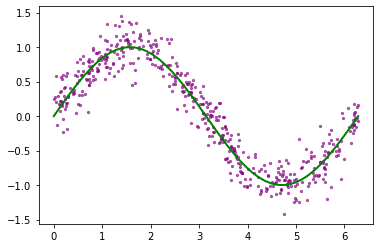

In [26]:
test_num = 500
alpha = 0.2
D = 1

def true_f(x):
    return np.sin(x)

X = 2 * np.pi * np.random.rand(test_num).reshape(test_num, D)
F = true_f(X)
Y = F + alpha * np.random.randn(len(F.reshape(-1))).reshape(F.shape)

test_dataset = [X, Y]
plt.scatter(X, Y, alpha=0.6, s=5, c='purple')

X_view = np.linspace(0, 2*np.pi)
F_view = true_f(X_view)
plt.plot(X_view, F_view, lw=2, c='g')

## 2.2 写像の表現

写像$f$を表現するのに様々な手法があります. 

例えば, 線形回帰では パラメータ$\mathbf w$を使って写像が$f_\mathbf{w}(\mathbf x_n) = (w_1x_{n1}+w_2x_{n2} +\dots +w_D x_{nD}) = \mathbf w^\mathrm{T} \mathbf{x}_n$と表現できると仮定します。


ここで、$X$については、既知なので、写像を推定する問題は、パラメータ$\mathbf w$の推定問題に帰着します。 

推定した写像による出力$f(x)$と教師信号であるラベル$y$の二乗誤差の総和を目的関数として定め, 目的関数の最小化するをパラメータ$w$を推定します.





k近傍法, Nadaraya-Watson推定は写像$f$を表現するのに、学習で用意されているラベル$y$を使う形で表現します。 

カーネル平滑化（またの名をNadaraya-Watson、重み付きカーネル平均）は、カーネル関数を使って以下の式で与えられます.


$$ f(\mathbf{x}) = \frac{\sum_{i=1}^N K_\lambda(\mathbf{x},\mathbf{x}_i)y_i}{\sum_{j=1}^N K_\lambda(\mathbf{x},\mathbf{x}_j)} $$

今回 カーネル関数$K_\lambda(\mathbf{x},\mathbf{x_j})$は次式で与えます.


$$ K_\lambda(\mathbf{x},\mathbf{x_j}) = \exp\left(\frac{-1}{2\sigma^2}||\mathbf{x} - \mathbf{x_j}||^2\right)$$


この式はガウス関数の式と等価です. 他のカーネル関数としてはイパネクニコフ関数や短形3次関数が一般的です.

In [67]:
sigma = 0.01

def kernel_smoother(X_zeta, X, Y, sigma):
    Dist = np.sum(np.square(X_zeta[:, None, :] - X[None, :, :]), axis=2)
    K = np.exp(-0.5 * Dist / sigma**2)
    
    F = K @ Y / np.sum(K, axis=1).reshape(X_zeta.shape[0], 1)
    return F

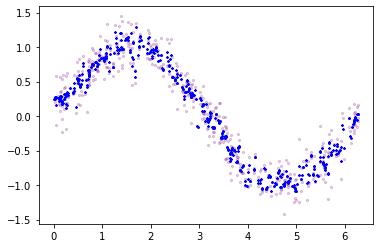

In [74]:
X_hat = kernel_smoother(X, X, Y, sigma)

X_view = np.linspace(0, 2*np.pi)[:, None]
F_view = kernel_smoother(X_view, X, Y, sigma)

plt.scatter(X, Y, alpha=0.2, s=5, c='purple')
plt.scatter(X, X_hat, s=4, c='blue', marker='*')

## Another Implemention：分母のnp.sumの計算を省略するパターン

In [159]:
X.shape

(500, 1)

In [160]:
Ones = np.ones(D).reshape(1, D)
Ones.shape

(1, 1)

In [161]:
Ones = np.ones(test_num).reshape(test_num, 1)
Ones.shape

(500, 1)

In [162]:
Y_new = np.concatenate((Y, Ones), axis=1)
Y_new.shape

(500, 2)

In [163]:
sigma = 0.5

In [164]:
Dist = np.sum(np.square(X[:, None, :] - X[None, :, :]), axis=2)
K = np.exp(-0.5 * Dist / sigma**2)
    
F_new = K @ Y_new

F = F_new[:, :D] / F_new[:, -1][:, None]
F.shape

(500, 1)

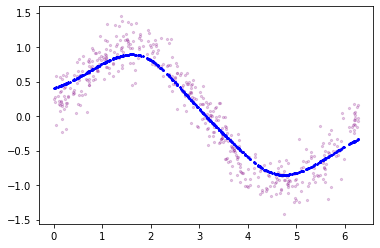

In [165]:
plt.scatter(X, Y, alpha=0.2, s=5, c='purple')
plt.scatter(X, F, s=4, c='blue', marker='*')